In [28]:
import json
from pathlib import Path
from itertools import cycle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RUNS = 2
DISTILLATIONS = ['featuremap', 'tucker', 'tucker_recomp']
RANKS = ['BATCH_SIZE,32,8,8', 'BATCH_SIZE,24,8,8', 'BATCH_SIZE,16,8,8', 'BATCH_SIZE,8,8,8']
METRICS = ['test_acc', 'train_acc', 'test_loss', 'train_loss']
TARGETS  = ['student', 'teacher', 'both']

def print_dict_structure(d, indent=0):
    spacing = "    " * indent
    for key, value in d.items():
        print(f"{spacing}├── {key}")
        if isinstance(value, dict):
            print_dict_structure(value, indent + 1)


In [54]:
def get_metrics(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return tuple(data[metric] for metric in METRICS)

def populate_dict(path):
    return dict(zip(METRICS, get_metrics(path)))

metrics_dict = {dist: {} for dist in DISTILLATIONS}
metrics_dict['tucker'] = {rank: {} for rank in RANKS}
metrics_dict['recomp'] = {target: {rank: {} for rank in RANKS} for target in TARGETS}

for run in range(RUNS):
    path = Path(f'experiments/featuremap/{run}/metrics.json')
    metrics_dict['featuremap'][run] = populate_dict(path)

for rank in RANKS:
    for run in range(RUNS):
        path = Path(f'experiments/tucker/{rank}/{run}/metrics.json')
        metrics_dict['tucker'][rank][run] = populate_dict(path)

for target in [TARGETS[1]]:
    for rank in RANKS:
        for run in range(2):
            path = Path(f'experiments/tucker_recomp/{target}/{rank}/{run}/metrics.json')
            metrics_dict['recomp'][target][rank][run] = populate_dict(path)


In [ ]:
def stack_arrays(d, metric):
    if metric in ['test_loss', 'train_loss']:
        arrays = [np.log10(np.array(d[run][metric])) for run in range(RUNS)]
    else: 
        arrays = [np.array(d[run][metric]) for run in range(RUNS)]
    stacked = np.stack(arrays)
    return np.mean(stacked, axis=0), np.std(stacked, axis=0, ddof=1)

metrics_processed = {dist: {} for dist in DISTILLATIONS}
metrics_processed['tucker'] = {rank: {} for rank in RANKS}
metrics_processed['recomp'] = {target: {rank: {} for rank in RANKS} for target in TARGETS}

metrics_processed['featuremap']['name'] = 'featuremap'
for metric in METRICS:
    mean, std = stack_arrays(metrics_dict['featuremap'], metric)
    metrics_processed['featuremap'][metric] = {'mean': mean, 'std': std}

for rank in RANKS:
    metrics_processed['tucker'][rank]['name'] = f'tucker_x{int(rank.split(',')[1]) / 64}'
    for metric in METRICS:
        mean, std = stack_arrays(metrics_dict['tucker'][rank], metric)
        metrics_processed['tucker'][rank][metric] = {'mean': mean, 'std': std}

for target in [TARGETS[1]]:
    for rank in RANKS:
        metrics_processed['recomp'][target][rank]['name'] = f'recomp_{target}_x{int(rank.split(',')[1]) / 64}'
        for metric in METRICS:
            mean, std = stack_arrays(metrics_dict['recomp'][target][rank], metric)
            metrics_processed['recomp'][target][rank][metric] = {'mean': mean, 'std': std}

def collect_named_subdicts(d, results=None):
    if results is None:
        results = []

    if isinstance(d, dict):
        if "name" in d:
            results.append(d)
        for value in d.values():
            collect_named_subdicts(value, results)
    
    return results

distillation_list =  collect_named_subdicts(metrics_processed)

yes


In [58]:
for dist in distillation_list:
    print(dist['name'])

featuremap
tucker_x0.5
tucker_x0.375
tucker_x0.25
tucker_x0.125
recomp_teacher_x0.5
recomp_teacher_x0.375
recomp_teacher_x0.25
recomp_teacher_x0.125


In [59]:
def plt_big(size):
    if size:
        plt.rcParams.update({
            'font.size': 20,
            'axes.titlesize': 26,
            'axes.labelsize': 24,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 20,
            'figure.titlesize': 26
        })
    else:
        mpl.rcParams.update(mpl.rcParamsDefault)

    return plt.subplots(figsize=(25, 25), dpi=300) if size else plt.subplots()

def plot_things(d_list, size):
    x = np.arange(150)

    def plot_metric(metric_key, ylabel, title, ylim=None, yticks=None):
        fig, ax = plt_big(size)
        fig.patch.set_facecolor('#dbdbdb')
        ax.set_facecolor('#dbdbdb')    
        local_color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

        for d in d_list:
            color = next(local_color_cycle)
            train_data = d[f'train_{metric_key}']
            test_data = d[f'test_{metric_key}']

            for data, linestyle, label in zip([train_data, test_data], ['dotted', 'solid'], ['Train', 'Test']):
                plt.plot(x, data['mean'], 
                         linestyle=linestyle,
                         label=d['name'] if label == 'Test' else None,
                         color=color)
                plt.fill_between(x,
                                 data['mean'] - data['std'],
                                 data['mean'] + data['std'],
                                 color=color, 
                                 alpha=0.2,
                                 edgecolor=color)

        plt.xlabel('Epoch')
        plt.xlim(0, 150)
        plt.ylabel(ylabel)
        if ylim:
            plt.ylim(*ylim)
        if yticks is not None:
            plt.yticks(yticks)
        plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    plot_metric('acc', 'Score', 'Accuracy', ylim=(0, 100), yticks=np.arange(0, 105, 5))
    plot_metric('loss', 'Log10 Loss', 'Loss')

def table_things():
    data = []
    for distillation in distillation_list:
        row = {'Name': distillation['name']}
        for metric in METRICS:
            row[metric] = round(distillation[metric]['mean'][-1], 2 if 'acc' in metric else 3) 
        data.append(row)
    print(pd.DataFrame(data))

In [60]:
table_things()

                    Name  test_acc  train_acc  test_loss  train_loss
0             featuremap     69.80      97.88      0.166      -0.230
1            tucker_x0.5     68.44      97.14      0.173       0.273
2          tucker_x0.375     68.50      97.05      0.175       0.345
3           tucker_x0.25     67.60      94.96      0.186       0.456
4          tucker_x0.125     64.24      92.40      0.204       0.624
5    recomp_teacher_x0.5     69.91      98.53      0.172      -0.131
6  recomp_teacher_x0.375     69.84      98.46      0.170      -0.111
7   recomp_teacher_x0.25     69.85      98.40      0.166      -0.104
8  recomp_teacher_x0.125     69.96      98.61      0.163      -0.129


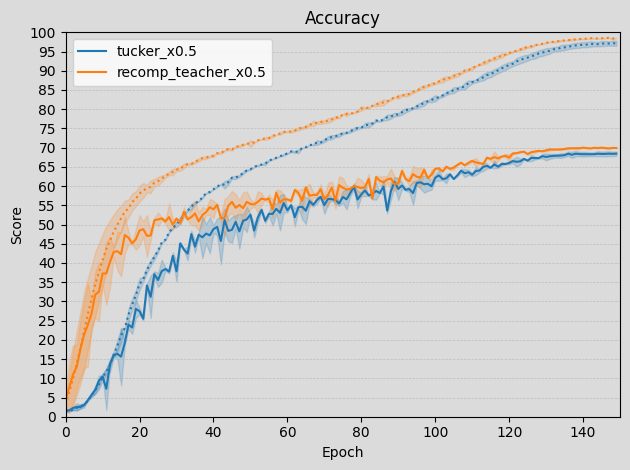

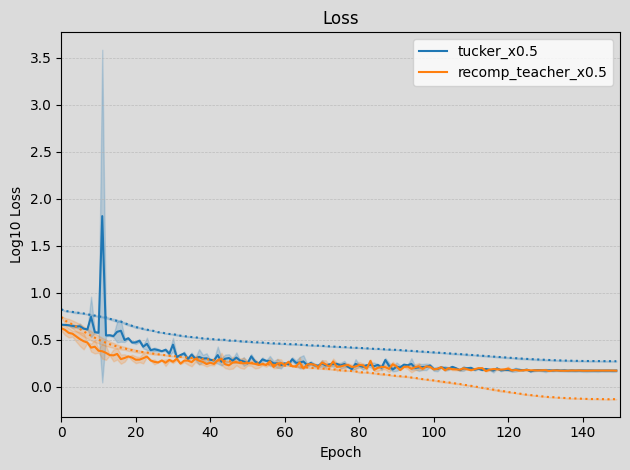

In [64]:
plot_things([d for d in distillation_list if '0.5' in d['name']], 0)

# MAYBE TODO: compare die featuremaps wat die verskillende models produce

In [4]:
import os

def tree(dir_path='.', prefix=''):
    """Print directory structure like the 'tree' command, ignoring .git."""
    try:
        entries = sorted(
            entry for entry in os.listdir(dir_path)
            if entry != '.git'  # Skip the .git directory
        )
    except PermissionError:
        print(prefix + "[Permission Denied]")
        return

    for entry in entries:
        full_path = os.path.join(dir_path, entry)
        print(prefix + '|-- ' + entry)
        if os.path.isdir(full_path):
            tree(full_path, prefix + '    ')

# Run the tree from the current directory
tree()


|-- .gitignore
|-- README.md
|-- analyzer_results_aggregator.ipynb
|-- analyzer_tucker_distillation.ipynb
|-- data
    |-- MNIST
        |-- raw
            |-- t10k-images-idx3-ubyte
            |-- t10k-images-idx3-ubyte.gz
            |-- t10k-labels-idx1-ubyte
            |-- t10k-labels-idx1-ubyte.gz
            |-- train-images-idx3-ubyte
            |-- train-images-idx3-ubyte.gz
            |-- train-labels-idx1-ubyte
            |-- train-labels-idx1-ubyte.gz
    |-- cifar-10-batches-py
        |-- batches.meta
        |-- data_batch_1
        |-- data_batch_2
        |-- data_batch_3
        |-- data_batch_4
        |-- data_batch_5
        |-- readme.html
        |-- test_batch
    |-- cifar-10-python.tar.gz
    |-- cifar-100-python
        |-- file.txt~
        |-- meta
        |-- test
        |-- train
    |-- cifar-100-python.tar.gz
|-- experiments
    |-- featuremap
        |-- 0
            |-- Accuracy.png
            |-- Loss.png
            |-- ResNet56.pth
        